## Change Runtime Type to GPU

> Runtime > Change runtime type > Hardware Accelerator > GPU

In [ ]:
!pip install bertopic

# 9.5 Topic Modeling


---

Topic modeling involves the use of algorithms and statistical models to automatically identify **topics or themes** that are present in unstructured data. Topic modeling is a form of unsupervised learning, which means that the algorithm is not given any pre-defined categories or labels to work with. Instead, it learngs to identify topics in the data based things like frequency and co-occurrence of words and phrases in data.

There are dozens of algorithms and models that can be used for topic modeling, each with its own strengths and weaknesses. Some of the most popular include Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), and BERTopic. BERT topic is based on the BERT transformer deep learning architecture. It uses a  graph-based approach to generate topics, which is a somewhat unique approach.


In this lesson, we will explore the basics recipe of topic modeling. By the end of the lesson, you should have the basic recipe to model topics of your own data.  


In [ ]:
# load our libraries
import warnings
warnings.filterwarnings('ignore')

# standard libries
import gzip
import json
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import re

# BERT Topic
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, models

# nltk, gensim, pprint and wordclouds
import nltk
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from pprint import pprint


# Import  libraries:


---


- gensim: A (NLP) library for topic modeling, document similarity, and text processing. We will use gensim to tokenize and preprocess the text data, create a dictionary and corpus, and train an LDA model.

- corpora: A sub-module of the gensim, it provides tools for working with text corpora, such as creating a dictionary and a corpus from a collection of preprocessed documents.

- pprint: Provides a more readable and visually appealing way to print complex data structures, such as the topics generated by LDA model.


## 1. load data
We'll start by load trump's tweets.

In [ ]:
# Load data
tweets = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/2023_BAN6005/main/module_5/data/trump_tweets.csv",
                     parse_dates=["tweet_date"])
tweets['tweet_date'] = tweets['tweet_date'].dt.date
tweets.head(5)


,tweet_id,tweet_text,is_retweet,is_deleted,device,favorites,retweets,tweet_timestamp,is_flagged,tweet_date
0,9.845500e+16,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02T18:07:48Z,False,2011-08-02
1,1.234650e+18,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03T01:34:50Z,False,2020-03-03
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17T03:22:47Z,False,2020-01-17
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12T20:10:58Z,False,2020-09-12
4,1.220000e+18,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17T13:13:59Z,False,2020-01-17


## 2. Convert and Cast reviewText to List


---


Convert 'reviewText' to string data type. Ensures that we are only dealing with strings, not numbers. We'll also want to convert the list of reviews to a List. For each review we'll pre-processes it.


In [ ]:
# Convert reviewText column to string
tweets['tweet_text'] = tweets['tweet_text'].astype(str)


# Cast the reviews to a list
tweet_list = tweets['tweet_text'].values.tolist()

In [ ]:
tweet_list[0]

'Republicans and Democrats have both created our economic problems.'

## 3. Tokenize and PreProcess Text


---


Tokenize and preprocess the text data by looping through the list of reviews and appending the preprocessed reviews to a new list called **processed_docs**. In this program, the gensim.utils.simple_preprocess() function is used to tokenize and preprocess the text by removing punctuation;  converting the text to lowercase and removing STOPWORDS (commonly used words in english)

In [ ]:
# get your stopwords
nltk.download('stopwords')
STOPWORDS = list(set(nltk.corpus.stopwords.words('english')))
STOPWORDS = STOPWORDS + ['https','rt','co','http']

# Tokenize and preprocess data
processed_docs = []
for tweet in tweet_list:

  # append each review after removing stopwords into the processed docs
  processed_docs.append([word for word in gensim.utils.simple_preprocess(tweet, deacc=True) if word not in STOPWORDS])

processed_docs[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['republicans', 'democrats', 'created', 'economic', 'problems']

## Sidebar - Singularization


---

Note: NKTK and similar libraries will  not always return the correct singular form of a word, as there are many irregular nouns in English. It is also worth noting that lemmatization and singularization are not exactly the same. Lemmatization attempts to reduce a word to its base form or lemma.Singularization specifically attempts to change a word to its singular form.

Anyway it takes a long time to singularize and lemmatize so we'll skip it but this is a typical pre-processing step that we'd want to normally perform.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize WordNet lemmatizer
wnl = WordNetLemmatizer()

# Singularize a word
word = "guitars"
singular_word = wnl.lemmatize(word, pos='n')

print("Singular of '{}' is '{}'".format(word, singular_word))

Singular of 'guitars' is 'guitar'


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 5. Create a Dictionary


---


Create a dictionary using the corpora.Dictionary() function from gensim. This function takes in a list of preprocessed documents and creates a unique integer id for each token in the documents.

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

## 6. Create a Corpus
Create a corpus using the doc2bow() function from gensim. This function converts each preprocessed document in the processed_docs list into a **bag-of-words representation**, which is a list of (token_id, token_count) tuples.

In [ ]:
# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## 7. TRAIN your LDA Model


---


Train your LDA model using the gensim.models.ldamodel.LdaModel() function. In this example, the LDA model is trained with 5 topics and 10 passes over the data.

Key HyperParameters:

- num_topics: The number of topics that the model should identify in the corpus. 1 = 1 topic, 10 = 10 topics. **Play with the number of topics**

- passes: The number of times the corpus should be processed by the LDA model. In general, increasing the number of passes can lead to more accurate and stable topic models but comes at increased  computational cost and training time. Generally start with 10 - it will warn you if it doesn't converge!

- alpha: The hyperparameter for the Dirichlet prior on the per-document topic distributions. Controls the sparsity of the document-topic distributions. generally set to "auto" don't bother with this one or other parameters.






In [ ]:
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=5, # change to your preffered number of topics.
                                            random_state=42,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Print topics
pprint(lda_model.print_topics())

[(0,
  '0.013*"people" + 0.010*"democrats" + 0.009*"border" + 0.008*"country" + '
  '0.008*"big" + 0.008*"news" + 0.008*"many" + 0.008*"would" + 0.007*"time" + '
  '0.007*"get"'),
 (1,
  '0.013*"last" + 0.012*"best" + 0.011*"foxnews" + 0.010*"north" + 0.010*"see" '
  '+ 0.010*"national" + 0.009*"watch" + 0.009*"meeting" + 0.009*"night" + '
  '0.009*"tonight"'),
 (2,
  '0.021*"hillary" + 0.018*"collusion" + 0.017*"russia" + 0.017*"fbi" + '
  '0.017*"clinton" + 0.014*"mueller" + 0.013*"crooked" + 0.012*"true" + '
  '0.009*"comey" + 0.007*"report"'),
 (3,
  '0.050*"great" + 0.041*"amp" + 0.041*"realdonaldtrump" + 0.033*"president" + '
  '0.029*"trump" + 0.021*"thank" + 0.015*"america" + 0.014*"today" + '
  '0.011*"make" + 0.010*"american"'),
 (4,
  '0.023*"house" + 0.023*"trump" + 0.018*"donald" + 0.012*"white" + '
  '0.011*"southern" + 0.008*"via" + 0.007*"shutdown" + 0.006*"committee" + '
  '0.006*"gop" + 0.005*"interview"')]


## 8. Analyze and Visualize Topics
---


1. Make a table of Review Topic assignment
2. Make a table of Topic Terms
3. Visualize Topics
  - barcharts (top N terms) by topic
  - wordclouds (color by topic)

## Make a Table of Topic Terms

In [ ]:
# Extract topic information
topics = lda_model.show_topics(num_topics=5, num_words=10, formatted=True)

# Create DataFrame
twitter_topics = pd.DataFrame()
for i, topic in topics:
    words = []
    weights = []
    for word_weight in topic.split("+"):
        weight, word = word_weight.split("*")
        words.append(word.strip().strip('"'))
        weights.append(float(weight))
    twitter_topics['topic_' + str(i)] = words

    # Add weights to DataFrame
    twitter_topics['topic_' + str(i) + '_weight'] = weights

# Print DataFrame
twitter_topics

,topic_0,topic_0_weight,topic_1,topic_1_weight,topic_2,topic_2_weight,topic_3,topic_3_weight,topic_4,topic_4_weight
0,people,0.013,last,0.013,hillary,0.021,great,0.050,house,0.023
1,democrats,0.010,best,0.012,collusion,0.018,amp,0.041,trump,0.023
2,border,0.009,foxnews,0.011,russia,0.017,realdonaldtrump,0.041,donald,0.018
3,country,0.008,north,0.010,fbi,0.017,president,0.033,white,0.012
4,big,0.008,see,0.010,clinton,0.017,trump,0.029,southern,0.011
5,news,0.008,national,0.010,mueller,0.014,thank,0.021,via,0.008
6,many,0.008,watch,0.009,crooked,0.013,america,0.015,shutdown,0.007
7,would,0.008,meeting,0.009,true,0.012,today,0.014,committee,0.006
8,time,0.007,night,0.009,comey,0.009,make,0.011,gop,0.006
9,get,0.007,tonight,0.009,report,0.007,american,0.010,interview,0.005


## MELT and Re-arange so you can Chart it!


---



In [ ]:
# Melt DataFrame
twitter_topics_melted = pd.melt(twitter_topics[["topic_0",
                                              "topic_1",
                                              "topic_2",
                                              "topic_3",
                                              "topic_4"]], var_name='Topic', value_name='Topic_Term')

twitter_topics_weight = pd.melt(twitter_topics[["topic_0_weight",
                                              "topic_1_weight",
                                              "topic_2_weight",
                                              "topic_3_weight",
                                              "topic_4_weight"]], var_name='Topic ID', value_name='Topic_Weight')

# Drop unnecessary columns
twitter_topics_weight = twitter_topics_weight.drop(['Topic ID'], axis=1)

twitter_topic_res = pd.concat([twitter_topics_melted,twitter_topics_weight],axis=1)
# Print melted DataFrame


twitter_topic_res.groupby("Topic").apply(lambda x: x.nlargest(5, "Topic_Weight"))


Topic       Topic_Term  Topic_Weight
Topic                                             
topic_0 0   topic_0           people         0.013
        1   topic_0        democrats         0.010
        2   topic_0           border         0.009
        3   topic_0          country         0.008
        4   topic_0              big         0.008
topic_1 10  topic_1             last         0.013
        11  topic_1             best         0.012
        12  topic_1          foxnews         0.011
        13  topic_1            north         0.010
        14  topic_1              see         0.010
topic_2 20  topic_2          hillary         0.021
        21  topic_2        collusion         0.018
        22  topic_2           russia         0.017
        23  topic_2              fbi         0.017
        24  topic_2          clinton         0.017
topic_3 30  topic_3            great         0.050
        31  topic_3              amp         0.041
        32  topic_3  realdonaldtrump         0.041
        33  topic_3        president         0.033
        34  topic_3            trump         0.029
topic_4 40  topic_4            house         0.023
        41  topic_4            trump         0.023
        42  topic_4           donald         0.018
        43  topic_4            white         0.012
        44  topic_4         southern         0.011

## Make Barcharts of Top N Terms per Topic


---



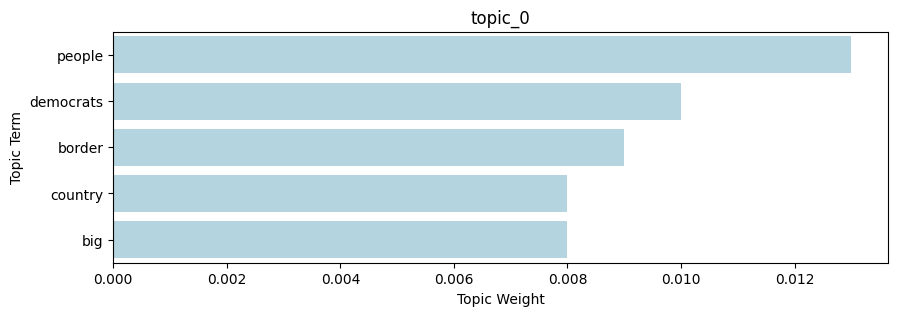

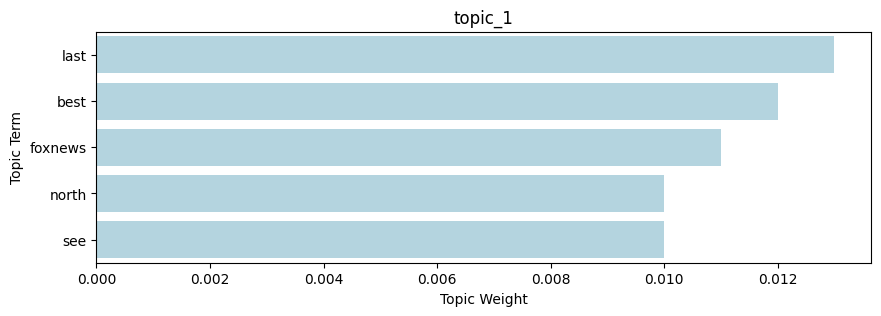

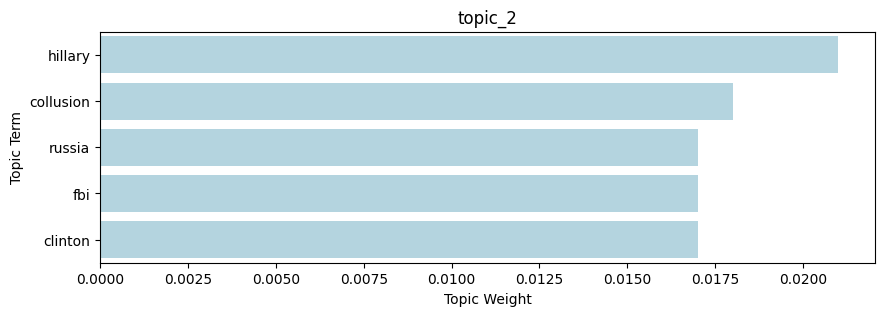

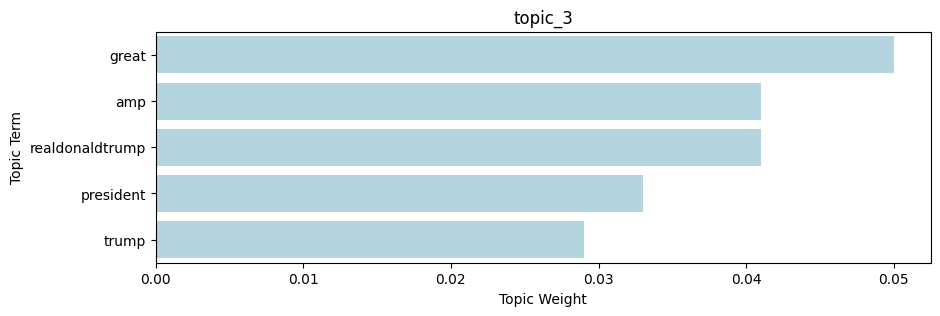

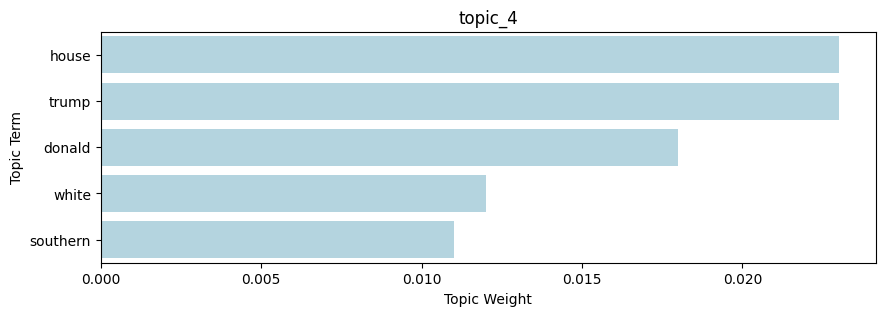

In [ ]:
# Group the data by topic
twitter_topic_list =  twitter_topic_res["Topic"].unique().tolist()

# Create a bar chart for each topic using Seaborn
for topic in twitter_topic_list:
    plt.figure(figsize=(10, 3))
    # get top 5
    topic_data = (twitter_topic_res
                  .query('Topic == @topic')
                  .nlargest(5, 'Topic_Weight'))
    sns.barplot(x='Topic_Weight', y='Topic_Term', data=topic_data, color='lightblue')
    plt.title(topic)
    plt.xlabel('Topic Weight')
    plt.ylabel('Topic Term')
    plt.show()

## Wordclouds!


---

Make Wordclouds where fontsize is based on topic weight, here i multiplied by 1000 and converted to integers so the wordcloud stunt would work.



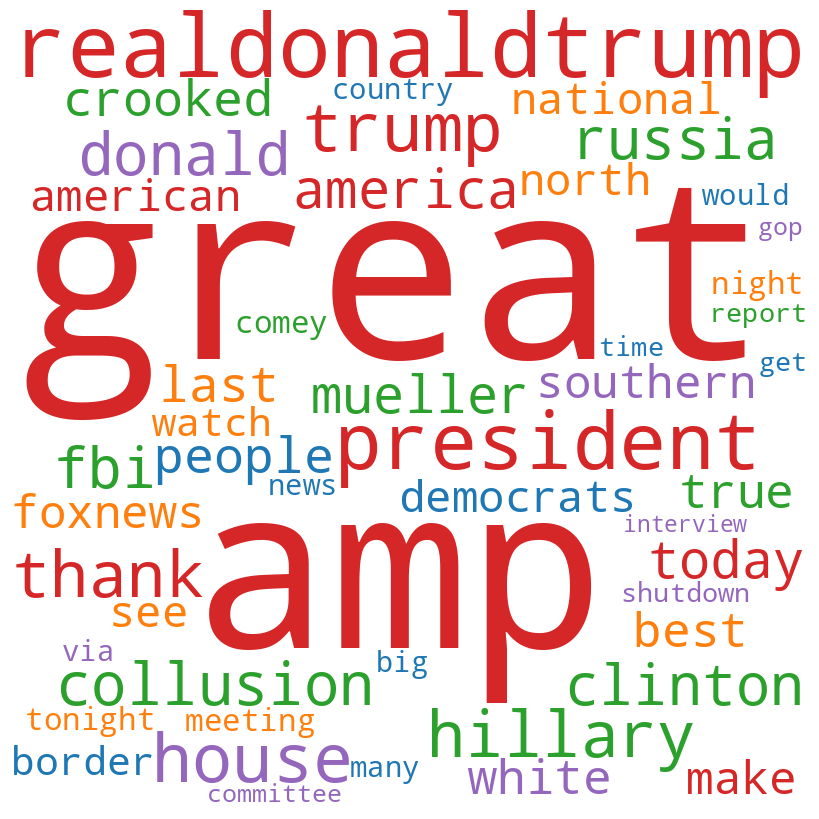

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# Convert the word weights to integers
twitter_topic_res['Topic_Weight_int'] = (1000*twitter_topic_res['Topic_Weight']).astype(int)

# Create a dictionary of word frequencies
word_freq = dict(zip(twitter_topic_res['Topic_Term'], twitter_topic_res['Topic_Weight_int']))

# Define the colors for each topic
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a color map with a different color for each topic
color_map = ListedColormap(colors)

# Define a function to get the color of a word based on its topic
def get_color(word, font_size, position, orientation, random_state=None, **kwargs):
    topic = twitter_topic_res.loc[twitter_topic_res['Topic_Term'] == word, 'Topic'].iloc[0]
    topic_idx = twitter_topic_res['Topic'].unique().tolist().index(topic)
    return colors[topic_idx]

# Create a word cloud with different color for each topic
wordcloud = WordCloud(background_color='white', width=800, height=800, colormap=color_map,
                      prefer_horizontal=1.0, color_func=get_color).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# BERT Topic


---

BERTopic is a topic modeling algorithm that leverages the BERT language model to generate embeddings for text data. It was introduced in the paper "BERTopic: Efficient and effective topic modeling with contextualized embeddings" by Joren Six, Tim Van de Cruys, and Marie-Francine Moens.

Why use BERTopic vs LDA? Traditional topic modeling algorithms, such as Latent Dirichlet Allocation (LDA), use **bag-of-words representations** to model topics. This approach has some limitations, mainly not taking into account word order and context.

BERTopic addresses these limitations by using BERT to generate document embeddings, which capture both word order and context. These embeddings are then clustered using an implementation of Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) algorithm to identify topics.

BERTopic has been shown to outperform traditional topic modeling algorithms on a range of text datasets, while also being faster and more scalable than other state-of-the-art methods.


The basic recipe.

1. import data
2. cast text column to string
3. convert text column to a list of strings
4. remove stopwords, junk and punctuation
5. train / apply BERTopic
  - remember to use nr_topics = n to control number of topics generated.
6. evaluate
  - document to topic count
  - visualize barchart topic terms
  - wordcloud(s)

Anyway, it generates "better" but more complex topics. let's see it in action.



In [ ]:
# Load data
twitter_reviews = pd.read_csv('https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/Musical_instruments_reviews.csv')


# Convert reviewText column to string
twitter_reviews['reviewText'] = twitter_reviews['reviewText'].astype(str)

# Cast the reviews to a list
reviews = twitter_reviews['reviewText'].values.tolist()

# get your stopwords
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

import string

# Define custom stopwords
custom_stopwords = ["the", "and", "a", "an", "in", "amp",
                    "it",
                    "these", "of", "to", "is", "that", "with", "for", "on", "was", "as", "it\'s", "this", "at", "but", "not", "be", "from", "by", "or", "if", "you", "are", "they", "can", "all", "my", "have", "has", "had", "been", "which", "there", "so", "than", "them", "their", "when", "who", "how", "what", "where", "why", "will", "would", "could"]

# Remove custom stopwords and punctuation from reviews
reviews = [text.lower() for text in reviews]
reviews = [' '.join([word.strip(string.punctuation) for word in text.split() if (word not in custom_stopwords and word.strip(string.punctuation) != "")]) for text in reviews]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Enable GPU acceleration for SentenceTransformer
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformer_model = SentenceTransformer('bert-base-nli-mean-tokens', device=device)

# Train BERTopic model LET IT RUNN!
model = BERTopic(embedding_model=transformer_model,
                 nr_topics = 10,
                 min_topic_size = 25,
                 top_n_words = 20,
                 #n_gram_range=(1,3)
                 )

# fit_transform transforems and fits a topic model to data based on pre-trained transformer model
topics, _ = model.fit_transform(reviews)

# Extract topics
topic_words = model.get_topics()
print("training complete")


training complete


In [ ]:
# Get the topic info dataframe from the model
topic_info = model.get_topic_info()

# Get the number of documents assigned to each topic
topic_counts = dict(zip(topic_info['Topic'], topic_info['Count']))

# Print the number of documents assigned to each topic
for topic_id, count in topic_counts.items():
    print(f"Topic {topic_id}: {count} documents")

Topic -1: 1506 documents
Topic 0: 142 documents
Topic 1: 8580 documents
Topic 2: 33 documents


In [ ]:

topic_8_indices = model.get_topic(5)
topic_8_indices



False

In [ ]:
# Convert the dictionary into a Pandas DataFrame
bert_topics = pd.DataFrame([(topic_id, term, weight) for topic_id, terms in topic_words.items() for term, weight in terms],
                  columns=['topic_id', 'term', 'weight'])

bert_topics.head(20)

,topic_id,term,weight
0,-1,great,0.031315
1,-1,one,0.030692
2,-1,sound,0.027849
3,-1,good,0.027598
4,-1,strings,0.026741
5,-1,like,0.025928
6,-1,use,0.025823
7,-1,more,0.024551
8,-1,very,0.024356
9,-1,just,0.023196


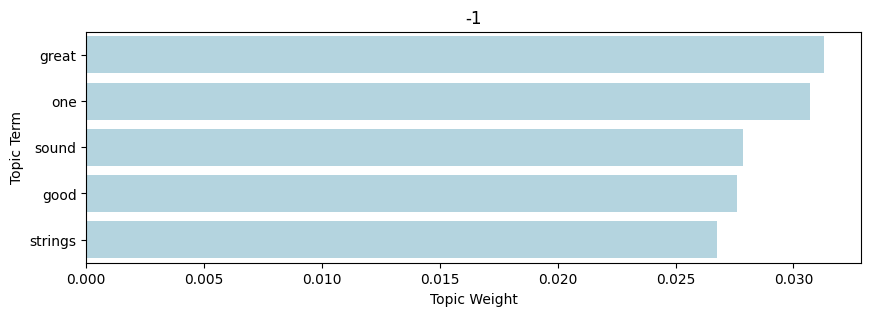

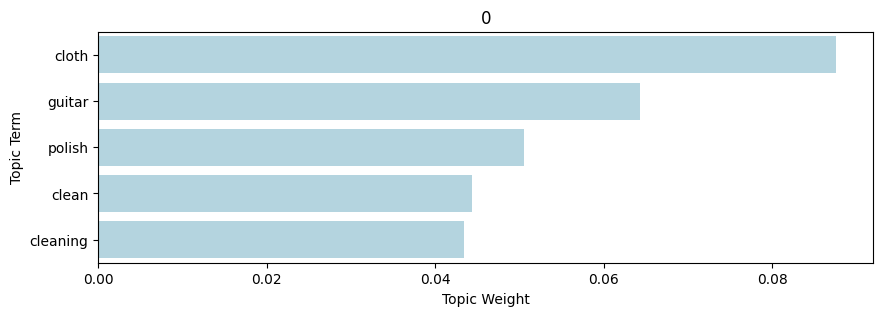

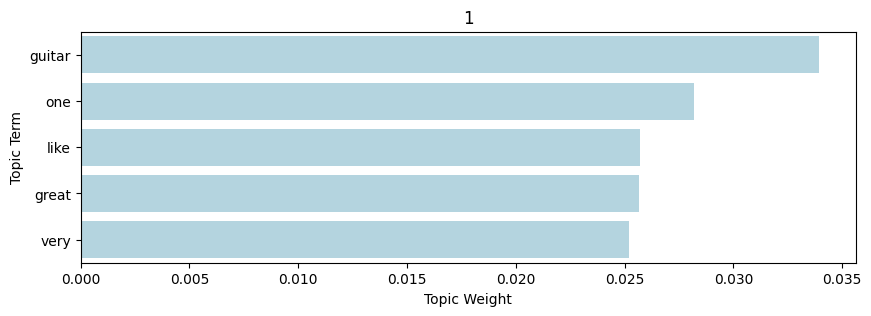

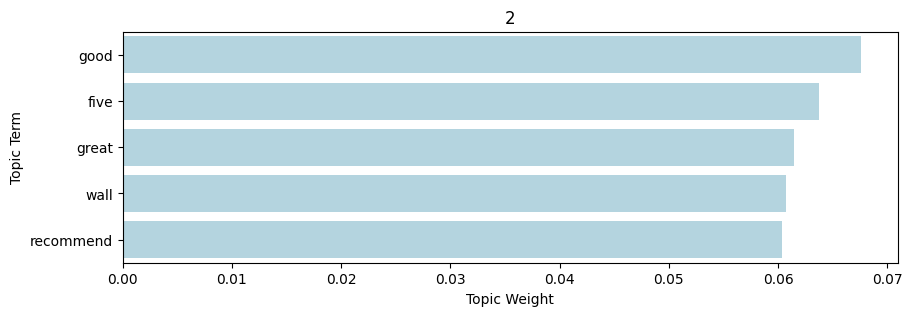

In [ ]:
# Group the data by topic
twitter_topic_list =  bert_topics["topic_id"].unique().tolist()

# Create a bar chart for each topic using Seaborn
for topic in twitter_topic_list:
    plt.figure(figsize=(10, 3))
    # get top 5
    topic_data = (bert_topics
                  .query('topic_id == @topic')
                  .nlargest(5, 'weight'))
    sns.barplot(x='weight', y='term', data=topic_data, color='lightblue')
    plt.title(topic)
    plt.xlabel('Topic Weight')
    plt.ylabel('Topic Term')
    plt.show()

In [ ]:
# need to make an integer to visualize w. a wordcloud!
bert_topics["weight_int"] = (bert_topics["weight"]*10000).astype(int)
bert_topics.head()

,topic_id,term,weight,weight_int
0,-1,great,0.031315,313
1,-1,one,0.030692,306
2,-1,sound,0.027849,278
3,-1,good,0.027598,275
4,-1,strings,0.026741,267


4
topic id: -1


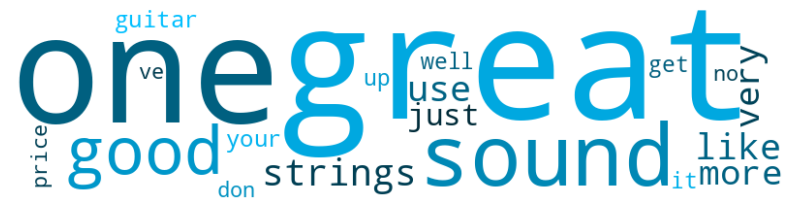

topic id: 0


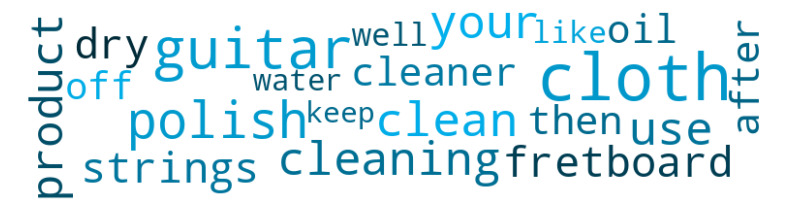

topic id: 1


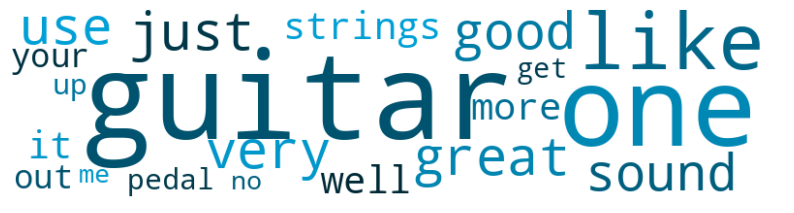

topic id: 2


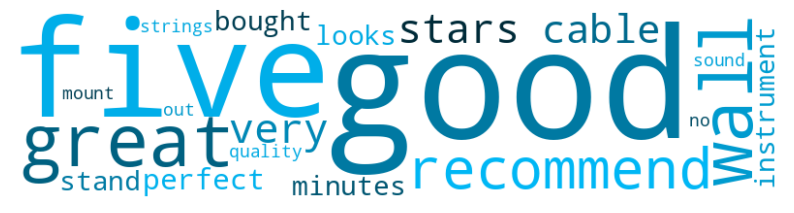

In [ ]:
import numpy as np
from wordcloud import get_single_color_func

topic_id_list = bert_topics["topic_id"].unique().tolist()

  # Define a function to generate random colors
def random_color(word, font_size, position, orientation, random_state=None, **kwargs):
      return tuple(np.random.randint(0, 255, 3))

print(len(topic_id_list))
# Generate word cloud for each topic
for topic in topic_id_list:
  print("topic id: {}".format(topic))
  topic_df = bert_topics.query("topic_id == @topic")
  # Create a dictionary of word frequencies
  term_freq = dict(zip(topic_df['term'], topic_df['weight_int']))

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=200, background_color='white', color_func=get_single_color_func('deepskyblue')).generate_from_frequencies(term_freq)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()


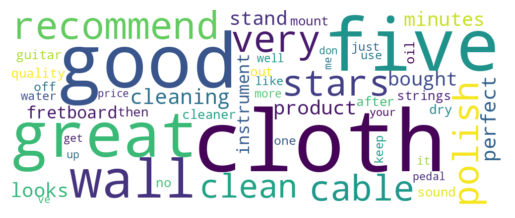

In [ ]:


term_freq = dict(zip(bert_topics['term'], bert_topics['weight_int']))

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(term_freq)

# Display the word cloud
# plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()